# Lab 16

Today, we will continue our journey through the classification task within supervised learning. Today we will explore some of the ingredients of decision trees before learning how to implement them in `sklearn`. Today's goals are: 

0. Explain why SVMs and decision trees are different approaches to classification 
1. Develop intuition for how to build decision trees
2. Learn how to build and fit decision trees in `sklearn`


![A comedic decision tree on deciding whether to major in cs.](csmajor.png)

### Imports for Today

We begin as usual, importing the packages and data that we need.

In [1]:
## Import block
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from six import StringIO

## Add a conda package!

If you got a (non-deprecation) error, you may need to exit jupyter and add `pydot` to your conda environment. 

### Helper Functions
We define some premade helper functions that will use to build your decision trees. These functions are heavily adapted from ["Decision Tree Algorithm in Python From Scratch"](https://towardsdatascience.com/decision-tree-algorithm-in-python-from-scratch-8c43f0e40173) by Eligijus Bujokas on TowardsDataScience.com.

In [2]:
def gini_index(data_pd: pd.DataFrame, class_var: str) -> float:
    """
    Given the observations of a binary class and the name of the binary class column
    calculate the gini index
    """
    # count classes 0 and 1
    count_A = np.sum(data_pd[class_var] == 0)
    count_B = np.sum(data_pd[class_var])

    # get the total observations
    n = count_A + count_B

    # If n is 0 then we return the lowest possible gini impurity
    if n == 0:
        return 0.0

    # Getting the probability to see each of the classes
    p1 = count_A / n
    p2 = count_B / n

    # Calculating gini
    gini = 1 - (p1 ** 2 + p2 ** 2)

    # Returning the gini impurity
    return gini

def info_gain(data_pd: pd.DataFrame, class_var: str, feature: str) -> float:
    """
    Calculates how much info we gain from a split compared to info at the current node
    """
    # compute the base gini impurity (at the current node)
    gini_base = gini_index(data_pd, class_var)

    # split on the feature
    node_left, node_right = split_bool(data_pd, feature)

    # count datapoints in each split and the whole dataset
    n_left = node_left.shape[0]
    n_right = node_left.shape[0]
    n = n_left + n_right
    
    # if n is 0 we return no info
    if n == 0:
        return 0.0

    # get left and right gini index
    gini_left = gini_index(node_left, class_var)
    gini_right = gini_index(node_right, class_var)

    # calculate weight for each node
    # according to proportion of data it contains from parent node
    w_left = n_left / n
    w_right = n_right / n

    # calculated weighted gini index
    w_gini = w_left * gini_left + w_right * gini_right

    # calculate the gain of this split
    gini_gain = gini_base - w_gini

    # return the best feature
    return gini_gain

In [3]:
# For function testing

#### Today's data

Today's data is adapted from a [dog breed trait dataset](https://www.kaggle.com/datasets/yonkotoshiro/dogs-breeds) posted by Al Chernyshev on Kaggle, as web scraped from breed profiles on https://dogtime.com. Each row represents a breed or breed mix. The dataset contains binary, numerical, and categorical data. For the first part of the lab, we use a subset of the available features to work with only binary variables.

Our goal is to classify dogs as "Good" or "Not Good" for Novice Owners.

In [4]:
## Import Data
dog_pd = pd.read_csv("lab16data-binary.csv", sep = ",", index_col = "Breed Name")

print(dog_pd.shape)

dog_pd.head()

(391, 4)


,Easy To Train,Kid-Friendly,High-Energy,Good For Novice Owners
Breed Name,,,,
Afador,False,False,True,False
Affenhuahua,False,False,True,True
Affenpinscher,False,False,True,True
Afghan Hound,False,True,True,False
Airedale Terrier,True,True,True,False


## From SVMs to Decision Trees

In our discussion of SVMs, we did not attempt to interpret nor to explain _why_ one data point gets labeled. In SVM, we have a boundary and we might be able to twist ourselves into an "explanation." However, we may want a transparent set of questions that lead us to our classifications.

* In SVM, we could say a dog is in group A because it lies above the line `class = 4 + 3*Easy-to-Train - 7*High-Energy`.
* In Decision Trees, we would say that this dog is in group A because it is easy to train and has high energy.

In the SVM example, it can be hard to interpret to the average person "above the line" with some equation. While in comparison, the answering of yes/no questions for the decision tree provides a straight-forward way to understand *why* a dog is or is not in one group. This is the intuition behind **decision trees.**

Decision trees are trees where each **branch** represents a decision based on a specific variable. Consider the following situation: We're a novice dog owner who wants to get a dog. We decide to classify dog breeds as "good" or "not good" for novice owners.

Our goal is to build something like this infographic that tells us how to decide whether or not a dog breed is good for novice owners: 

![dogBreeds.png](dogBreeds.png)

At the top **node,** we represent our first decision. Then based on whether a dog is easy to train, we either examine the dog's energy levels or the dog's kid-friendliness. 

The bottom nodes of a decision tree are called **leaves.** Each leaf is the group of data points that followed the series of decisions encoded in that branch. (A _leaf_ is a node with no branches under it.)

## Finding the Best Way to Split the Data

The central question of decision trees is: "What decision will give me the best split of my data?" To address this question we need to 1) understand how to split the data, and 2) how to evaluate the "goodness" of a split. 

In our example about dogs, currently, we don't know whether a dog's size, energy, or some other characteristic will help us best sort dogs into "good" or "not good" for novice owners.

We start by trying to split the data into two groups based on one variable, then repeat this decision for each other variable in the dataset.

Let's start by splitting our dog breeds based on whether they are "Easy to Train".

In [5]:
# observe that "Easy to Train" is a boolean variable - either True or False
dog_pd['Easy To Train'].head()

Breed Name
Afador              False
Affenhuahua         False
Affenpinscher       False
Afghan Hound        False
Airedale Terrier     True
Name: Easy To Train, dtype: bool

In [6]:
# split our data into two dataframes: easy/not easy to train
easy_to_train = dog_pd[dog_pd['Easy To Train']]
hard_to_train = dog_pd[~dog_pd['Easy To Train']]

In [7]:
# check our output shapes
print(dog_pd.shape)
print(easy_to_train.shape)
print(hard_to_train.shape)

(391, 4)
(198, 4)
(193, 4)


For our later convenience, let's functionalize the process of splitting a dataframe based on a binary variable:

In [8]:
## split on a boolean/binary variable
## should look very similar to your code in the block above
def split_bool(data_pd, column_name):
    """Returns two pandas dataframes:
    one where the specified variable is true,
    and the other where the specified variable is false"""
    node_left = data_pd[data_pd[column_name]]
    node_right = data_pd[~data_pd[column_name]]
    
    return node_left, node_right

easy_to_train, hard_to_train = split_bool(dog_pd, 'Easy To Train')

In [9]:
# For function testing

In [10]:
# check our output shapes that use the above function 
# Do they match the above?

print(dog_pd.shape)
print(easy_to_train.shape)
print(hard_to_train.shape)

(391, 4)
(198, 4)
(193, 4)


As another example, let's repeat our split on the variable "Kid-Friendly" to split dog breeds by whether or not they are good with kids.

In [11]:
kid_friendly, not_kid_friendly = split_bool(dog_pd, 'Kid-Friendly')

In [12]:
# check our output shapes
print(dog_pd.shape)
print(kid_friendly.shape)
print(not_kid_friendly.shape)

(391, 4)
(288, 4)
(103, 4)


## How do we define the "Best" Split?

We need a way to measure whether "Easy to Train" or "Kid-Friendly" is better for splitting up dogs into groups of "Good" or "Not Good" for Novice Owners.

***Note:*** *In this section, we will use the term "purity" as it is term that is often used in the literature. We—your instructor and pedagogical partner—do not like this term, but feel that you should hear it due to its existence in the decision tree space.*

In an ideal scenario, splitting on one of these variables would let us send all the dogs who are "Good" for Novice Owners to one leaf of the tree, and send all the dogs who are "Not Good" for Novice Owners to the other leaf of the tree. But in our imperfect world, we'll usually end up with *impure leaves*—leaves which are not perfectly separated by our target classification. We aim to quantify the "purity", also known as the "homogeneity", of each node on our tree.

![A visual diagram showing the spectrum from most pure to least pure.](homogeneity.png)

There are multiple ways to measure the homogeneity of a node, including:
* Gini Impurity Index
* Entropy
* Missclassification

In the helper functions at the top of the lab, we have an implementation of the Gini Impurity Index. For a given leaf's group of data, `gini_leaf()` returns a number between 0 and 1, where 1 means the data is completely homogeneous (all the same class) and 0 means the data as not homogeneous at all (there's the same amount of data of both classes at the node).

In [13]:
## find gini impurity index for each of our split groups
## syntax: gini_index(leaf_data, class_var)
easy_to_train_gini = gini_index(easy_to_train, 'Good For Novice Owners')
hard_to_train_gini = gini_index(hard_to_train, 'Good For Novice Owners')

kid_friendly_gini = gini_index(kid_friendly, 'Good For Novice Owners')
not_kid_friendly_gini = gini_index(not_kid_friendly, 'Good For Novice Owners')

In [14]:
# print our gini values
print("Easy to Train Gini Indices:")
print(easy_to_train_gini)
print(hard_to_train_gini)
print("Kid-Friendly Gini Indices:")
print(kid_friendly_gini)
print(not_kid_friendly_gini)

Easy to Train Gini Indices:
0.45097439036832976
0.37370130741764873
Kid-Friendly Gini Indices:
0.43728298611111105
0.3468752945612217


**Question**: Among the "Easy to Train" and "Kid-Friendly" variables, do one decision's nodes seem to have lower Gini Impurities than the other decision?

**Your Thoughts Here**

Using our chosen metric of homogeneity, information gain (`info_gain()`) quantifies how much we learn from a given decision. (We learn more if we can split the data into more homogenous nodes.) If you want to read more about the calculations behind the Gini Index and Information Gain, see the resources at the end of the lab.

For now, we'll run with applying `info_gain()` to our decisions, and we'll split on the variable that lets us gain the most information.

In [15]:
## apply info_gain to each split
## syntax is: info_gain(data_decide, decision_var, class_var)
info_easy_to_train = info_gain(dog_pd, 'Easy To Train', 'Good For Novice Owners')
info_kid_friendly = info_gain(dog_pd, 'Kid-Friendly', 'Good For Novice Owners')

In [16]:
# print our info gain values
print("Info gain from Easy to Train:", info_easy_to_train)
print("Info gain from Kid-Friendly: ", info_kid_friendly)

Info gain from Easy to Train: 0.008093667726169318
Info gain from Kid-Friendly:  0.02282299908458274


**Question:** Among "Easy To Train" and "Kid-Friendly", which variable gives us more information for classifying dog breeds as "Good for Novice Owners"? Does this correspond with the node which had lower Gini Impurities above?

**Your Thoughts Here**

The variable whose split gives us the most information is the best first split in our decision tree. In other words, splitting on this variable is the best first decision at the top of our decision tree.

Let's build a function which tests all possible features to split on and returns the best one.

### A Note on Types in Python:

The functions in this lab specify input and output types in the function declarations. The function declaration  
`def best_split(data_pd: pd.DataFrame, class_var: str) -> float:`  
is equivalent to  
`def best_split(data_pd, class_var):`  
but gives us the additional information that `data_pd` is a Pandas DataFrame, `class_var` is a string, and the return from the function is a float.

***We do not expect you to code with types in Python for this course,*** but this lab aims to give you some exposure in case you encounter them in a future context.

In [17]:
def best_split(data_pd: pd.DataFrame, class_var: str, exclude_features: list = []) -> float:
    """
    Returns the name of the best feature to split on at this node.
    If the current node contains the most info (all splits lose information), return None.
    """
    # compute the base gini index (at the current node)
    gini_base = gini_index(data_pd, class_var)

    # initialize max_gain and best_feature
    max_gain = 0
    best_feature = None

    # create list of features of data_pd not including class_var
    features = data_pd.columns[:-1]

    # will be useful later - can skip for now
    # remove features we're excluding
    # (already made decision on this feature)
    features = [f for f in features if f not in exclude_features]

    # test a split on each feature
    for feature in features:
        info = info_gain(data_pd, class_var, feature)

        # check whether this is the greatest gain we've seen so far
        # and thus the best split we've seen so far
        if info > max_gain:
            best_feature = feature
            max_gain = info

    # return the best feature
    return best_feature

In [18]:
# block for testing your code



In [19]:
best_split(dog_pd, "Good For Novice Owners")

'Kid-Friendly'

In [20]:
best_split(dog_pd, "Good For Novice Owners", exclude_features=['Kid-Friendly'])

'Easy To Train'

### A Note on Splitting Non-Binary Data

Very few real data sets contain only binary variables. Whether a variable is categorical, ordinal, or numerical, the presence of more than two possible values of the variable in the data set means that there are multiple ways to split the data set into two groups.

For example:
* For a categorical variable with levels ABC, there are three potential ways to split the data into two groups: AB|C, AC|B, or BC|A.
* For an ordinal variable with rankings 1-5, there are four potential decision boundaries: var <= 1, 2, 3, or 4 (Note that <= 5 is not a valid boundary, as the condition will be true for all data and thus we divide the data into only one group.)
* For a numerical variable with values 2.3, 2.6, 3.1, 3.7, and 4.1, we can form decision boundaries between each value of the data similar to the ordinal variable above, or based on moving averages of subsets of the data.

Note that the number of possible decisions on a variable grows rapidly as the number of distinct values of the variable increase.

We will not code decisions on non-binary data from scratch, but it’s important to remember that when we talk about finding the “best possible decision” at each level of a decision tree, we’re often considering multiple decisions for each variable.

**Question (optional, but recommended):**  
If a dataset contains n variables, we’ve established that we have more than n options to consider for the “best possible decision.” In the worst case, what is the order of decisions we need to consider?

**Your Thoughts Here**

## Building a Tree of Decisions
After we decide on the best first decision in our tree, we have two nodes of data. We consider each node individually, and repeat the whole process again to see which of the remaining potential decisions is the next best split for that node. Often, the next best decision is different on each side of the tree.

In other words, we take the nodes that result from our first decision, and we recursively build a decision tree from each node.

**Question:** When we have a recursive process, we need both the recursive step and a base case (aka stopping condition). What are potential base cases for building a decision tree?

**Your Thoughts Here**

Let's start writing the **pseudocode** for a recursive decision tree algorithm. Our goal at each node is to:

0. (Stop if we reach the base case)
1. Determine which split/decision gives us the most information
2. Make the split on that variable
3. Continue recursively on each of the resulting two nodes

In [21]:
## initial decision tree algorithm PSEUDOCODE
## this doesn't need to run
## just sketch out how you would follow the steps above

# you may need to pass additional parameters to this function call
# depending on your stopping condition
def decision_tree(node_data: pd.DataFrame, class_var: str):
    # 0. stop at the base case
    
    # 1. determine which decision gives us the most information
    
    # 2. make the split according to the best decision
    
    # 3. continue recursively on each of the resulting two nodes
    
    pass
    

### Other Stopping Conditions
Common stopping conditions for a decision tree algorithm include, but are not limited to:

* When the tree has reached *n* levels of depth
* When none of the remaining possible decisions/splits at a node provide more information than the info we already have at the node
* When we run out of potential decisions\*\*
* When our splits result in leaves smaller than size *n*

\*\*Note that for binary data, we run out of potential decisions when we've split on every variable. For non-binary data, we could make multiple splits on a given variable between different levels of the numbers or among different combinations of categories—thus, we have many, many possible decisions to consider.

**Question:** Why would it be valuable to have shorter trees (Trees with depth <= *n*)?

**Your Thoughts Here**

*(Hint: Think about overfitting...)*

## Building a Decision Tree
Now, let's turn your decision tree into working code. We'll be implementing a simplified version of the decision tree in [this post](https://towardsdatascience.com/decision-tree-algorithm-in-python-from-scratch-8c43f0e40173). For the scope of this lab, we'll just build the structure of the decision tree—we will not add functionality to produce a classification from the tree. See the source post for an example of how to classify observations using your decision tree.

The outline provided is based on a max depth of 2 as a stopping condition. As a challenge, try to add another stopping condition as described in the above section.

As a reminder, here is our ***recursive*** decision tree algorithm:

0. (Stop if we reach the base case)
1. Determine which split/decision gives us the most information
2. Make the split on that variable
3. Continue recursively on each of the resulting two nodes

In [22]:
## build a decision tree from a node of data
def build_decision_tree(node_data: pd.DataFrame, class_var: str, depth: int = 0, exclude_features: list = []) -> None:
    # 0. stop at the base case
    max_depth = 2
    if depth >= max_depth:
        return
    
    # 1. determine which decision gives us the most information
    best_feature = best_split(node_data, class_var, exclude_features)
    print(f"{'>'*(depth+1)}Splitting {node_data.shape[0]} data points on {best_feature}")
    
    # 2a. if best_feature == None, don't split further
    if best_feature == None:
        print(f"{'>'*(depth+1)}No best next split.")
        return
    
    # 2b. else, make the split according to the best decision
    else:
        data_left, data_right = split_bool(node_data, best_feature)
        print(f"{'>'*(depth+1)}Produces {data_left.shape[0]} True data points and {data_right.shape[0]} False data points")
        
        # and exclude this feature at future levels of the tree
        exclude_features.append(best_feature)
    
    # 3. continue recursively on each of the resulting two nodes
    build_decision_tree(data_left, class_var, depth + 1, exclude_features)
    build_decision_tree(data_right, class_var, depth + 1, exclude_features)
    return

In [23]:
# block for testing your code

In [24]:
build_decision_tree(dog_pd, "Good For Novice Owners")

>Splitting 391 data points on Kid-Friendly
>Produces 288 True data points and 103 False data points
>>Splitting 288 data points on Easy To Train
>>Produces 160 True data points and 128 False data points
>>Splitting 103 data points on None
>>No best next split.


**Question:** Can you describe in words how the tree splits the data?

**Your Thoughts Here**

## Decision Trees in `sklearn`

Now that we have some basic intuition about decision trees, let's build a decision tree classifier using `sklearn`. As with other machine learning tools in `sklearn`, we will first specify our decision tree model, and then fit the decision tree model to some data—similar to other `sklearn` classifiers we used before. 

Since the `sklearn` decision tree implementation can form decisions on non-binary features, let's import our full dog breed dataset.

In [25]:
# import full dataset
dog_full = pd.read_csv("lab16data.csv", sep = ",", index_col = "Breed Name")
dog_data = dog_full.to_numpy(dtype = np.float16)

print(dog_full.shape)

dog_full.head()

(391, 11)


,Size,"Avg. Life Span, years",Wanderlust Potential,Adaptability,All Around Friendliness,Health And Grooming Needs,Physical Needs,Easy To Train,Kid-Friendly,High-Energy,Good For Novice Owners
Breed Name,,,,,,,,,,,
Afador,4,11,4,2.4,3.00,3.2,4.00,False,False,True,False
Affenhuahua,1,16,2,3.0,3.00,3.2,3.33,False,False,True,True
Affenpinscher,1,13,2,3.2,3.33,2.4,3.33,False,False,True,True
Afghan Hound,4,11,5,4.0,4.67,2.0,3.67,False,True,True,False
Airedale Terrier,3,12,4,2.2,4.00,2.4,4.33,True,True,True,False


In [26]:
dog_data[:5, :]

array([[ 4.  , 11.  ,  4.  ,  2.4 ,  3.  ,  3.2 ,  4.  ,  0.  ,  0.  ,
         1.  ,  0.  ],
       [ 1.  , 16.  ,  2.  ,  3.  ,  3.  ,  3.2 ,  3.33,  0.  ,  0.  ,
         1.  ,  1.  ],
       [ 1.  , 13.  ,  2.  ,  3.2 ,  3.33,  2.4 ,  3.33,  0.  ,  0.  ,
         1.  ,  1.  ],
       [ 4.  , 11.  ,  5.  ,  4.  ,  4.67,  2.  ,  3.67,  0.  ,  1.  ,
         1.  ,  0.  ],
       [ 3.  , 12.  ,  4.  ,  2.2 ,  4.  ,  2.4 ,  4.33,  1.  ,  1.  ,
         1.  ,  0.  ]], dtype=float16)

In [27]:
# Split the data into the input variables and the target classes
in_dog = dog_data[:,:-1]
out_class = dog_data[:,-1]

# Get the variable names 
var_names = list(dog_full.columns)[:-1]
print(var_names)

['Size', 'Avg. Life Span, years', 'Wanderlust Potential', 'Adaptability', 'All Around Friendliness', 'Health And Grooming Needs', 'Physical Needs', 'Easy To Train', 'Kid-Friendly', 'High-Energy']


In [28]:
# Specify our model
# note: the default for the `criterion` parameter is 'gini' - but 'entropy' is also an option
dt = DecisionTreeClassifier()

In [29]:
# Fit our model to the data
dt.fit(in_dog, out_class)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Umm... this is not easy to "look" at. Referring to [this post](https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93), we adjust their code to create a visual output of our decision tree (double-click the image to zoom in): 

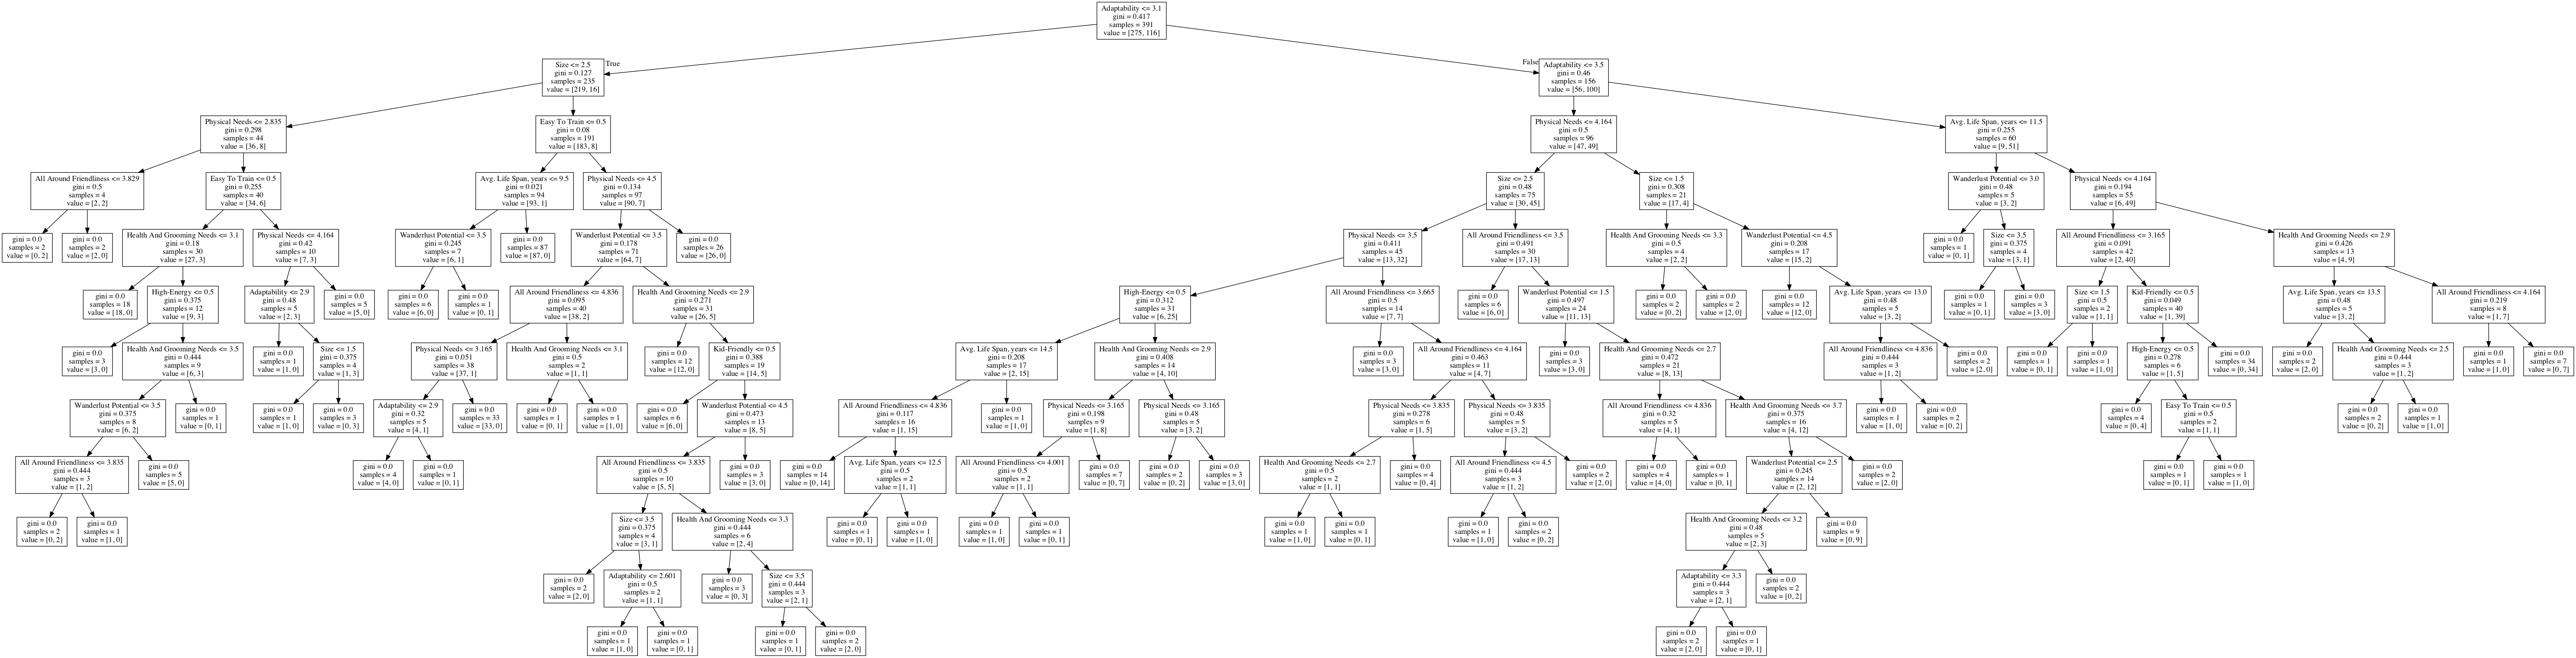

In [30]:
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())

**Question** What do you notice about this image? What is encoded? What is left out? 

**Your Thoughts Here**

To wrap up, we'll predict whether the first five dogs in the dataset are good for novice owners. (This is bad practice to predict from our training data—don't use training data like this when you validate your models.)

In [31]:
# Predict for the first five dogs
dt.predict(in_dog[:5,:])

array([0., 1., 1., 0., 0.], dtype=float16)

### Next time

Next time, we will look at ensemble methods which aggregates several methods together. The specific example that we will explore are **random forests.** Random forests are based on a collection of decision trees. 

## Final Thoughts

In reality, every dog is unique and may not conform to the description of its breed. While breed descriptions may be useful guidelines for those hoping to adopt a new dog, it is best for each family to meet the individual dog to get a sense of whether the dog will be a good fit.

And remember, regardless of fit for an individual family, every dog is a [good dog](https://www.inverse.com/science/59234-can-dogs-really-truly-understand-us). 

For this lab, you have two choices for how you finish up this lab. To get credit, you **only** need to do one of the following choices: 

**Choice 1 - Final Questions:**
1. Save the image of your `sklearn` decision tree. 
2. Choose a dog breed in the dataset.
3. Using your `sklearn` image of your decision tree, decide if the breed is good for novice owners. 
4. Compare your result to the result from the classifier. Are they the same?
5. Compare your result and the classifier's result to the original classification in the dataset. Are they correct?
6. (Optional) If you have knowledge of this dog breed, would you agree with the result of the classification? Is this dog good for novice owners?

**Choice 2 - Final Questions:**
1. Explain at least one scenario in which use of this classifier could be potentially harmful.
2. Name at least one other scenario where forming decisions via a classifier could be potentially harmful and/or unethical. Explain why.
3. What are some considerations you would want to keep in mind when deciding whether use of a classifier is appropriate in a given scenario?

Share your thoughts in a post on the **#lab16_submission** channel on slack.

If your have questions from this lab, post them to **#lab_questions** with the same preamble (i.e. starting with **Lab16**). If you have the same question, please use one of the emoji's to upvote the question. If you would like to answer someone's question, please use the thread function. This will tie your answer to their question.

#### Resources consulted 

0. [Data Source - Dogs Breeds on Kaggle](https://www.kaggle.com/datasets/yonkotoshiro/dogs-breeds)
1. [Decision Tree Algorithm in Python From Scratch](https://towardsdatascience.com/decision-tree-algorithm-in-python-from-scratch-8c43f0e40173)
1. [SCIKIT-LEARN : DECISION TREE LEARNING I - ENTROPY, GINI, AND INFORMATION GAIN](https://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php)
1. [`sklearn` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
1. [`sklearn` further tree information](https://scikit-learn.org/stable/modules/tree.html)
1. [Google Developers: Let’s Write a Decision Tree Classifier from Scratch - Machine Learning Recipes #8 (YouTube)](https://www.youtube.com/watch?v=LDRbO9a6XPU)
1. [StatQuest: Decision Trees (YouTube)](https://www.youtube.com/watch?v=7VeUPuFGJHk)
1. [ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf)
1. [SDS 293 Notes by R. Jordan Crouser](http://www.science.smith.edu/~jcrouser/SDS293/)
1. [Decision Tree In Python](https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93)
1. [Decision Tree Algorithm With Hands On Example](https://medium.com/datadriveninvestor/decision-tree-algorithm-with-hands-on-example-e6c2afb40d38)


This lab was created by Kathleen R. Hablutzel, Smith College '23J, as part of a Pedagogical Partnership with Professor Katherine M. Kinnaird in Spring 2022. Parts of the introduction and conclusion to the lab are borrowed from previous versions of Lab 16.